<a href="https://colab.research.google.com/github/anna-marshalova/fall-detection/blob/main/fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
ROOT = '/content/'

#Downloading Data

In [2]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=ba26fc06ee87f1ea43c6c851b0376f547c8e57bac569a925af05e21195a5f3de
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

In [4]:
import json
KEY_PATH = os.path.join(ROOT, 'roboflow_api_key.json')
with open(KEY_PATH) as key_json:
    roboflow_api_key = json.load(key_json)['key']

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("roboflow-universe-projects").project("fall-detection-ca3o8")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Fall-Detection-1 in yolov5pytorch:: 100%|██████████| 9006/9006 [00:05<00:00, 1683.92it/s]


#Preprocessing Data

In [7]:
DATA_DIR = os.path.join(ROOT, 'Fall-Detection-1')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [8]:
torch.set_default_dtype(torch.float32)

##Dataset

In [9]:
import torch
from torch.utils.data import Dataset
import os
import pandas as pd
import cv2

class DetectionDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.labels_dir = os.path.join(self.data_dir, 'labels')
        self.image_ids = sorted([fname.replace('.jpg', '') for fname in os.listdir(self.images_dir)])
        self.transform=transform

    def get_coordinates(self, labels):
        max_coordinates = [0, 0, 0, 0]
        max_area = 0
        for label in labels:
            coordinates = [float(c) for c in label.strip().split()[1:]]
            width, height = coordinates[2:]
            area = abs(width * height)
            if area > max_area:
                max_coordinates = coordinates
        return np.array(max_coordinates)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        label_path = os.path.join(self.labels_dir, f'{image_id}.txt')
        image = cv2.imread(image_path)
        with open(label_path) as label_file:
            labels = label_file.readlines()
            coordinates = self.get_coordinates(labels)
        sample = {'image': image, 'label':coordinates}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
train_dataset = DetectionDataset(TRAIN_DIR)
val_dataset = DetectionDataset(VAL_DIR)
test_dataset = DetectionDataset(TEST_DIR)

## Visulaization

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def display(sample, pred_bbox = None):
    image, gt_bbox = sample.values()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = add_bbox(image, gt_bbox, border_color = [255, 255, 0])
    if pred_bbox:
        image = add_bbox(image, pred_bbox, border_color = [255, 0, 0])
    plt.imshow(image)

def add_bbox(image, yolo_coordinates_norm, border_color = [0, 0, 0]):
    img_height, img_width = image.shape[:2]
    yolo_coordinates_abs = get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width)
    left, right, bottom, top = get_corner_coordinates(yolo_coordinates_abs)
    cv2.rectangle(image, (left, top), (right, bottom), border_color, 1)
    return image

def get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width):
    scale = [img_width, img_height, img_width, img_height]
    yolo_coordinates_norm = np.array(yolo_coordinates_norm)
    yolo_coordinates_abs = (yolo_coordinates_norm * scale).astype(int)
    return yolo_coordinates_abs

def get_corner_coordinates(yolo_coordinates_abs):
    x, y, w, h = yolo_coordinates_abs
    left, right = x - w//2, x + w//2
    bottom, top = y - h//2, y + h//2
    return left, right, bottom, top

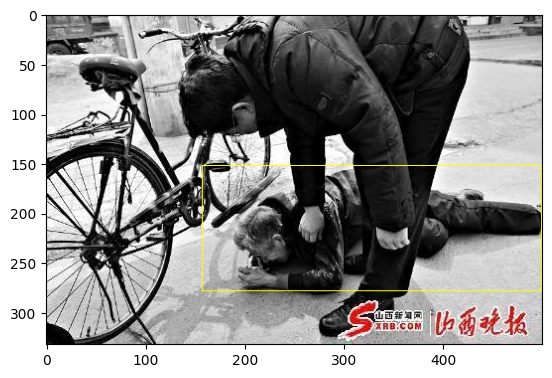

In [16]:
import random
i = random.randint(0, len(train_dataset))
display(train_dataset[i])

#Model

## Collator

In [6]:
import torch

def collate_fn(data):
    images = []
    labels = []
    width_limit, height_limit = 500, 500
    max_width, max_height = 0, 0
    for sample in data:
        height, width = sample['image'].shape[:2]
        if width > max_width:
            max_width = width
        if height > max_height:
            max_height = height
    max_width = min(max_width, width_limit)
    max_height = min(max_height, height_limit)

    for sample in data:
        image = sample['image']
        height, width = image.shape[:2]
        if width > max_width:
            height = int(height/width*max_width)
            width = max_width
            image = cv2.resize(image, (width, height))
        if height > max_height:
            width = int((width/height)*max_height)
            height = max_height
            image = cv2.resize(image, (width, height))
        top = max(max_height - height, 0)
        left = max(max_width - width, 0)
        image = cv2.copyMakeBorder(image, top, 0, left, 0, cv2.BORDER_CONSTANT)
        images.append(torch.tensor(image, dtype = torch.float32))
        labels.append(torch.tensor(sample['label'], dtype = torch.float32))
    return {'image': torch.stack(images).permute(0, 3, 1, 2), 'label':torch.stack(labels)}

##DataLoaders

In [24]:
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)

next(iter(train_loader))['image'].shape

torch.Size([2, 3, 300, 500])

##Model

In [18]:
from torchvision.models import vgg19
from torch import nn
import torch.nn.functional as F

class Detector(nn.Module):

    def __init__(self):
        super().__init__()
        self.vgg = vgg19(weights='DEFAULT')
        self.features = self.vgg.features
        #self.avgpool = self.vgg.avgpool
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.VGG_FEATURE_MAP_SIZE = 512*2*2
        self.fc = nn.Linear(in_features=self.VGG_FEATURE_MAP_SIZE, out_features=4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.avgpool(self.features(x))
        features = features.flatten(1, 3)
        output = F.sigmoid(self.fc(features))
        return output


In [19]:
model = Detector()
# (batch_size, channels, height, width)
model(torch.ones(2, 3, 128, 128))
#model(next(iter(train_loader))['image'])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 65.5MB/s]


tensor([[0.4549, 0.5056, 0.5279, 0.5042],
        [0.4549, 0.5056, 0.5279, 0.5042]], grad_fn=<SigmoidBackward0>)

#Training

##IoU

In [20]:
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1[:, 0], bbox1[:, 1], bbox1[:, 2], bbox1[:, 3]
    left1, right1, bottom1, top1 = get_corner_coordinates((x1, y1, w1, h1))

    x2, y2, w2, h2 = bbox2[:, 0], bbox2[:, 1], bbox2[:, 2], bbox2[:, 3]
    left2, right2, bottom2, top2 = get_corner_coordinates((x2, y2, w2, h2))

    intersection_left = torch.max(left1, left2)
    intersection_right = torch.min(right1, right2)
    intersection_bottom = torch.max(bottom1, bottom2)
    intersection_top = torch.min(top1, top2)

    intersection_width = torch.clamp(intersection_right - intersection_left, min=0)
    intersection_height = torch.clamp(intersection_top - intersection_bottom, min=0)
    intersection_area = intersection_width * intersection_height

    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area

    return iou

## One epoch

In [21]:
from tqdm import tqdm
import torch
from typing import Callable, Tuple
import gc

def train_one_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: Callable,
) -> Tuple[float, float]:

    model.train()

    train_running_loss = 0.0
    train_running_iou = 0
    total_epoch_steps = int(len(dataloader.dataset)/dataloader.batch_size)

    tq = tqdm(enumerate(dataloader), total=total_epoch_steps)

    for step, batch in tq:
        images, target = batch.values()
        images, target = images.to(device), target.to(device)
        outputs = model(images)

        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        preds = model(images)
        train_running_iou += calculate_iou(target, preds).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        gc.collect()
        torch.cuda.empty_cache()

        tq.set_description(f"Train Loss: {train_running_loss/(step+1):.4f}, Train IoU: {train_running_iou/(step+1):.2f}")

    train_loss = train_running_loss/len(dataloader.dataset)
    train_iou = 100. * train_running_iou/len(dataloader.dataset)
    return train_loss, train_iou


def validate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: Callable,
):

    model.eval()

    val_running_loss = 0.0
    val_running_iou = 0

    with torch.no_grad():
        inference_steps = int(len(dataloader.dataset)/dataloader.batch_size)
        tq = tqdm(enumerate(dataloader), total=inference_steps)

        for step, batch in tq:

            images, target = batch.values()
            images = images.to(device)
            target = target.to(device)

            outputs = model(images)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            preds = model(images)
            val_running_iou += calculate_iou(target, preds).sum().item()
            tq.set_description(f"Train Loss: {val_running_loss/(step+1):.4f}, Train IoU: {val_running_iou/(step+1):.2f}")

        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_iou/len(dataloader.dataset)
        return val_loss, val_accuracy

## Trainining process

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Detector().to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
train_loss , train_accuracy = [], []

epochs = 4

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_iou)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_iou:.2f}")
    val_loss, val_iou = validate(model, test_loader, criterion)
    print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_iou:.2f}")

In [539]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

#Code Drafts (messy💀)

In [498]:
import numpy as np
import matplotlib.pyplot as plt

def display(sample, pred_bbox = None):
    image, gt_bbox = sample.values()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = add_bbox(image, gt_bbox, border_color = [255, 255, 0])
    if pred_bbox:
        image = add_bbox(image, pred_bbox, border_color = [255, 0, 0])
    plt.imshow(image)

def add_bbox(image, yolo_coordinates_norm, border_color = [0, 0, 0]):
    img_height, img_width = image.shape[:2]
    corners_norm = get_corner_coordinates(yolo_coordinates_norm)
    left, right, bottom, top = get_absolute_coordinates(corners_norm, img_height, img_width)
    cv2.rectangle(image, (left, top), (right, bottom), border_color, 1)
    return image

def get_absolute_coordinates(coordinates_norm, img_height, img_width):
    left, right, bottom, top = coordinates_norm
    return int(left*img_width), int(right*img_width), int(bottom*img_height), int(top*img_height)

tensor([0.0239], dtype=torch.float64, grad_fn=<DivBackward0>)


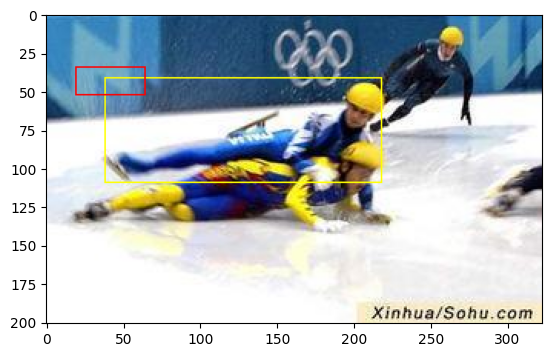

In [509]:
import random

i = random.randint(0, len(train_dataset))
sample = train_dataset[i]
image, label = sample.values()
image_input = torch.tensor(image, dtype=torch.float).unsqueeze(0).permute(0,3,1,2).to(device)
pred_bbox = model(image_input).cpu()
print(calculate_iou(torch.tensor(label).unsqueeze(0), pred_bbox))
display(sample, pred_bbox = pred_bbox.view(4).tolist())

In [508]:
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1[:, 0], bbox1[:, 1], bbox1[:, 2], bbox1[:, 3]
    left1, right1, bottom1, top1 = get_corner_coordinates((x1, y1, w1, h1))

    x2, y2, w2, h2 = bbox2[:, 0], bbox2[:, 1], bbox2[:, 2], bbox2[:, 3]
    left2, right2, bottom2, top2 = get_corner_coordinates((x2, y2, w2, h2))

    intersection_left = torch.max(left1, left2)
    intersection_right = torch.min(right1, right2)
    intersection_bottom = torch.max(bottom1, bottom2)
    intersection_top = torch.min(top1, top2)

    intersection_width = torch.clamp(intersection_right - intersection_left, min=0)
    intersection_height = torch.clamp(intersection_top - intersection_bottom, min=0)
    intersection_area = intersection_width * intersection_height

    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area

    return iou

In [470]:
def get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width):
    scale = [img_width, img_height, img_width, img_height]
    yolo_coordinates_norm = np.array(yolo_coordinates_norm)
    yolo_coordinates_abs = (yolo_coordinates_norm * scale).astype(int)
    return yolo_coordinates_abs

def get_corner_coordinates(yolo_coordinates_abs):
    x_center, y_center, bbox_width, bbox_height = yolo_coordinates_abs
    left = x_center - bbox_width/2
    right = x_center + bbox_width/2
    bottom = y_center - bbox_height/2
    top = y_center + bbox_height/2
    return left, right, bottom, top

In [439]:
def calculate_iou(image, box1, box2):
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    x_min1 = x1 - w1 / 2
    x_min2 = x2 - w2 / 2
    intersection_x_min = torch.max(x_min1, x_min2)

    y_min1 = y1 - h1 / 2
    y_min2 = y2 - h2 / 2
    intersection_y_min = torch.max(y_min1, y_min2)

    x_max1 = x1 + w1 / 2
    x_max2 = x2 + w2 / 2
    intersection_x_max = torch.min(x_max1, x_max2)

    y_max1 = y1 + h1 / 2
    y_max2 = y2 + h2 / 2
    intersection_y_max = torch.min(y_max1, y_max2)

    intersection_width = torch.clamp(intersection_x_max - intersection_x_min, min=0)
    intersection_height = torch.clamp(intersection_y_max - intersection_y_min, min=0)
    intersection_area = intersection_width * intersection_height

    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area

    return iou

In [408]:
i = random.randint(0, len(train_dataset))
sample = train_dataset[i]
image, label = sample.values()
IoU(image, label, label)

[119 152 167 110]


AxisError: ignored

In [514]:
batch = next(iter(train_loader))
yolo_coordinates_norm = batch['label']
image = batch['image']
image_input = torch.tensor(image, dtype=torch.float).to(device)
pred_bbox = model(image_input).cpu()

calculate_iou(yolo_coordinates_norm, pred_bbox).mean()

<ipython-input-514-7b7e01506c4d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(image, dtype=torch.float).to(device)


tensor(0.4698, grad_fn=<MeanBackward0>)

In [413]:
def mask_bbox(image, yolo_coordinates_norm):
    img_height, img_width = image.shape[2:]
    yolo_coordinates_abs = get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width)
    corners = np.apply_along_axis(get_corner_coordinates, 1, yolo_coordinates_abs)
    print(corners)
    mask = np.zeros_like(image)
    print(mask.shape)
    mask[:, bottom:top, left:right, :] = 1
    return mask

def IoU(image, gt_bbox, pred_bbox):
    gt_mask = mask_bbox(image, gt_bbox)
    pred_mask = mask_bbox(image, pred_bbox)
    union = np.count_nonzero(gt_mask + pred_mask)
    intersection = (gt_mask * pred_mask).sum()
    return intersection/union

In [322]:
def get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width):
    scale = [img_width, img_height, img_width, img_height]
    yolo_coordinates_norm = np.array(yolo_coordinates_norm)
    yolo_coordinates_abs = (yolo_coordinates_norm * scale).astype(int)
    return yolo_coordinates_abs

def get_corner_coordinates(yolo_coordinates_abs):
    #x_center, y_center, bbox_width, bbox_height = yolo_coordinates_abs
    #left, right = x_center - bbox_width//2, x_center + bbox_width//2
    #bottom, top = y_center - bbox_height//2, y_center + bbox_height//2
    left = yolo_coordinates_abs[:, 0] - yolo_coordinates_abs[:, 2]//2
    right = yolo_coordinates_abs[:, 0] + yolo_coordinates_abs[:, 2]//2
    bottom = yolo_coordinates_abs[:, 1] - yolo_coordinates_abs[:, 3]//2
    top = yolo_coordinates_abs[:, 1] + yolo_coordinates_abs[:, 3]//2
    return left, right, bottom, top

In [331]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 13.6 MB/s eta 0:00:00


In [385]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def mean_ap(pred_norm, gt_norm):
    mean_avg_precision = MeanAveragePrecision()
    pred_abs = get_absolute_coordinates(pred_norm, img_height, img_width)
    pred_corner = np.apply_along_axis(get_corner_coordinates, 1, pred_abs)
    gt_abs = get_absolute_coordinates(gt_norm, img_height, img_width)
    gt_corner = np.apply_along_axis(get_corner_coordinates, 1, gt_abs)
    return mean_avg_precision(pred_corner.tolist(), gt_corner.tolist())

batch = next(iter(train_loader))
yolo_coordinates_norm = batch['label']
images = batch['image']
img_height, img_width = images.shape[2:]
mean_ap(yolo_coordinates_norm, yolo_coordinates_norm)

ValueError: ignored

In [399]:
def mean_ap(pred_norm, gt_norm):
    scores = torch.ones_like(pred_norm[:, 0])
    labels = torch.ones_like(pred_norm[:, 0]).int()
    preds = [dict(boxes=pred_norm, scores=scores, labels=labels)]
    target = [dict(boxes=gt_norm, scores=scores, labels=labels)]
    metric = MeanAveragePrecision(box_format='cxcywh')
    metric.update(preds, target)
    return metric.compute()

mean_ap(yolo_coordinates_norm, yolo_coordinates_norm)

{'map': tensor(1.),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_small': tensor(1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1250),
 'mar_10': tensor(1.),
 'mar_100': tensor(1.),
 'mar_small': tensor(1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

In [ ]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=1)

jaccard(pred, target)

In [383]:
a.tolist()

[[108, 182, 260, 342],
 [197, 311, 220, 310],
 [106, 190, 260, 332],
 [106, 246, 151, 227],
 [90, 360, 54, 332],
 [187, 421, 128, 484],
 [130, 318, 0, 192],
 [190, 314, 120, 482]]

In [381]:
def get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width):
    scale = np.array([img_width, img_height, img_width, img_height])
    yolo_coordinates_norm = np.array(yolo_coordinates_norm)
    yolo_coordinates_abs = (yolo_coordinates_norm * scale).astype(int)
    return yolo_coordinates_abs

def get_corner_coordinates(yolo_coordinates_abs):
    x_center, y_center, bbox_width, bbox_height = yolo_coordinates_abs[:]
    left, right = x_center - bbox_width//2, x_center + bbox_width//2
    bottom, top = y_center - bbox_height//2, y_center + bbox_height//2
    return left, right, bottom, top

In [347]:
get_absolute_coordinates(yolo_coordinates_norm, img_height, img_width)

tensor([[306, 194, 219, 350],
        [244, 223, 260, 235],
        [376, 307, 246, 195],
        [197, 264, 209, 313],
        [248, 316, 496, 258],
        [142, 367, 284, 162],
        [226, 222, 426, 312],
        [176, 344, 281, 207]], dtype=torch.int32)

In [280]:
i = random.randint(0, len(train_dataset))
sample = train_dataset[i]
image, label = sample.values()
image_input = torch.tensor(image, dtype=torch.float).unsqueeze(0).permute(0,3,1,2).to(device)
print(IoU(image, label, label))

AttributeError: ignored

In [189]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 6.3 MB/s eta 0:00:00


In [174]:
pred_bbox.view(4).tolist()

[0.49805766344070435,
 0.5915851593017578,
 0.4380016326904297,
 0.28892743587493896]

In [53]:
pred_bbox = pred_bbox()
display(sample, pred_bbox = pred_bbox)

RuntimeError: ignored

In [39]:
mse = torch.nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
mse(input, target)

tensor(1.8933, grad_fn=<MseLossBackward0>)